# Health Insurance fraud detection using Medicare Providers dataset 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib
import os
from pathlib import Path
%matplotlib inline

In [2]:
#Change directory to root
path = Path(os.getcwd())
root_dir = path.parent.absolute()
os.chdir(str(root_dir))

## 4. Modeling

### 4.1. Preparation

In [3]:
df_cms = pd.read_csv('data\processed\Sampled_Medicare_Data.csv')

In [4]:
df_cms.head()

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year,Fraud
0,1144645441,Nurse Practitioner,KY,F,15,106.000,69,504.000,315,1.593,103833.000,25026.710,2016,0
1,1215036645,General Surgery,TN,M,35,42.000,68,128.000,69,1.985,176562.400,34067.570,2017,0
2,1598203416,Certified Registered Nurse Anesthetist (CRNA),FL,M,15,82.000,73,23.000,21,4.936,35451.000,5020.170,2018,0
3,1386608115,Dermatology,NC,F,32,385.000,74,4810.000,1146,0.789,630920.000,214255.900,2018,0
4,1497773790,Optometry,MA,M,8,62.000,71,153.000,140,0.915,21300.000,13016.190,2017,0


In [5]:
#Drop year and NPI for training
df_cms=df_cms.drop(columns=['Rndrng_NPI','year'])
df_cms.head()

,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,Fraud
0,Nurse Practitioner,KY,F,15,106.000,69,504.000,315,1.593,103833.000,25026.710,0
1,General Surgery,TN,M,35,42.000,68,128.000,69,1.985,176562.400,34067.570,0
2,Certified Registered Nurse Anesthetist (CRNA),FL,M,15,82.000,73,23.000,21,4.936,35451.000,5020.170,0
3,Dermatology,NC,F,32,385.000,74,4810.000,1146,0.789,630920.000,214255.900,0
4,Optometry,MA,M,8,62.000,71,153.000,140,0.915,21300.000,13016.190,0


In [6]:
df_cms.shape

(12470, 12)

In [7]:
#Null Values
df_cms.isna().any()

Rndrng_Prvdr_Type            False
Rndrng_Prvdr_State_Abrvtn    False
Rndrng_Prvdr_Gndr            False
Tot_HCPCS_Cds                False
Bene_Male_Cnt                False
Bene_Avg_Age                 False
Tot_Srvcs                    False
Tot_Benes                    False
Bene_Avg_Risk_Scre           False
Tot_Sbmtd_Chrg               False
Tot_Mdcr_Pymt_Amt            False
Fraud                        False
dtype: bool

In [8]:
#Duplicated rows
dups=df_cms[df_cms.duplicated()] 
print('Duplicated rows :',dups.shape[0])

Duplicated rows : 0


In [9]:
#Check invalid values
print('Negative submitted charges :',df_cms[df_cms['Tot_Sbmtd_Chrg'] < 0].shape[0])
print('Negative Medicare payment :',df_cms[df_cms['Tot_Mdcr_Pymt_Amt'] < 0].shape[0])
print('Negative Total benefits:',df_cms[df_cms['Tot_Benes'] < 0].shape[0])
print('Negative Total services:',df_cms[df_cms['Tot_Srvcs'] < 0].shape[0])

Negative submitted charges : 0
Negative Medicare payment : 0
Negative Total benefits: 0
Negative Total services: 0


In [10]:
#Check dtypes
df_cms.dtypes

Rndrng_Prvdr_Type             object
Rndrng_Prvdr_State_Abrvtn     object
Rndrng_Prvdr_Gndr             object
Tot_HCPCS_Cds                  int64
Bene_Male_Cnt                float64
Bene_Avg_Age                   int64
Tot_Srvcs                    float64
Tot_Benes                      int64
Bene_Avg_Risk_Scre           float64
Tot_Sbmtd_Chrg               float64
Tot_Mdcr_Pymt_Amt            float64
Fraud                          int64
dtype: object

In [11]:
df_cms[['Rndrng_Prvdr_Gndr','Rndrng_Prvdr_Type',"Rndrng_Prvdr_State_Abrvtn"]].nunique()

Rndrng_Prvdr_Gndr             2
Rndrng_Prvdr_Type            80
Rndrng_Prvdr_State_Abrvtn    57
dtype: int64

- __Convert _'Rndrng_Prvdr_Gndr'_ To binary (0/1)__


- __Apply One-Hot enconding to _'Rndrng_Prvdr_Type' & 'Rndrng_Prvdr_State_Abrvtn'___

In [12]:
def convert_cat(df_cms):
    gender_map = {'M': 1,'F': 0}
    df_conv=df_cms.copy()
    df_conv['Rndrng_Prvdr_Gndr']=df_cms['Rndrng_Prvdr_Gndr'].map(gender_map)
    df_conv=pd.get_dummies(df_conv)
    return df_conv

In [13]:
df=convert_cat(df_cms)

In [14]:
print('new data shape :',df.shape)

new data shape : (12470, 147)


### 4.2. Model training

#### Preprocessing :

In [15]:
from sklearn.model_selection import train_test_split
from numpy import mean
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from sklearn import svm
from collections import Counter
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay ,plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score ,roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from imblearn.under_sampling import TomekLinks 
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.over_sampling import ADASYN 
from imblearn.ensemble import EasyEnsembleClassifier 
from sklearn.decomposition import PCA
import joblib

In [16]:
#Train/Test split
X = df.drop(columns='Fraud')
y = df['Fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, stratify=y)

In [17]:
train_test = {'Subset':['Train', 'Test'],
              'Percent':[y_train.value_counts()[1]/y.value_counts()[1]*100, 
                   y_test.value_counts()[1]/y.value_counts()[1]*100],
        'Non_fraudulent':[y_train.value_counts()[0], y_test.value_counts()[0]],
        
        'Fraudulent':[y_train.value_counts()[1], y_test.value_counts()[1]],
        'Fraudulent %' :[y_train.value_counts()[1]/len(X_train)*100,
                         y_test.value_counts()[1]/len(X_test)*100]
       }
df_size = pd.DataFrame(train_test)
df_size

,Subset,Percent,Non_fraudulent,Fraudulent,Fraudulent %
0,Train,80.032,8978,998,10.004
1,Test,19.968,2245,249,9.984


In [18]:
#Save train/test data as csv
#train
X_train.to_csv("data/final/X_train.csv",index=False) 
y_train.to_csv("data/final/y_train.csv",index=False) 

#test
X_test.to_csv("data/final/X_test.csv",index=False) 
y_test.to_csv("data/final/y_test.csv",index=False) 

#### Tests :

##### Functions :

In [19]:
def Base_eval(model,X_train,y_train,rep):
    #Evaluate model
    scores = { 'Recall': 'recall',
            'ROC_AUC': 'roc_auc',
            'Precision': 'precision',
            'F1_Score': 'f1'
            }

    #Scaling 
    scal = MinMaxScaler()

    #define pipeline
    if(type(model).__name__ in ['RandomForestClassifier']):
        #tree based models don't need scaling
        steps = [('model', model)]
    else :
        steps = [('scal',scal),('model', model)]
    pipeline = Pipeline(steps=steps)

    #rep x Stratified 5 folds
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=rep, random_state=1)


    #Evaluate :
    start = time.time()
    scores = cross_validate(model, X_train, y_train, scoring=scores, cv=cv)
    stop = time.time()

    # if((stop - start)>=60):
    #   print(f"Eval time : {(stop - start)/60} min")
    # else :
    #   print(f"Eval time : {(stop - start)} sec")

    return scores

In [20]:
def Evaluate(model,X_train,y_train,rep,method,minr):
  
    #Base Model : model

    #Evaluate model
    scores = { 'Recall': 'recall',
            'ROC_AUC': 'roc_auc',
            'Precision': 'precision',
            'F1_Score': 'f1'
            }
  
    #Sampling
    if(method=='rus'):
        samp = RandomUnderSampler(sampling_strategy=minr/(1-minr))
    elif(method=='nearmiss'):
        samp=NearMiss(sampling_strategy=minr/(1-minr)) 
    elif(method=='ros'):
        samp = RandomOverSampler(sampling_strategy=minr/(1-minr))
    elif(method=='ros/rus'):
        over=RandomOverSampler(sampling_strategy=minr/(1-minr))
        under=RandomUnderSampler(sampling_strategy=1)
    elif(method=='smote'):
        samp=SMOTE()
    elif(method=='adasyn'):
        samp=ADASYN()
   
  
    #Scaling 
    scal = MinMaxScaler()
  
    #define pipeline
    if(type(model).__name__ in ['RandomForestClassifier']):
        #tree based models don't need scaling
        if(method=='ros/rus'):
            steps = [('over', over),('under',under) ,('model', model)]
        else:
            steps = [('samp', samp) ,('model', model)]
    else :
        if(method=='ros/rus'):
            steps = [('over', over),('under',under) ,('scal',scal) , ('model', model)]
        else :
            steps = [('samp', samp) ,('scal',scal)  ,('model', model)]

    pipeline = Pipeline(steps=steps)

    #rep x Stratified 5 folds
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=rep, random_state=1)

    #Evaluate :
    start = time.time()
    scores = cross_validate(pipeline, X_train, y_train, scoring=scores, cv=cv)
    stop = time.time()

    # if((stop - start)>=60):
    #   print(f"Eval time : {(stop - start)/60} min")
    # else :
    #   print(f"Eval time : {(stop - start)} sec")

    return scores

In [21]:
def grid_search(model,grid,X_train,y_train,method,minr,rep,score):

    #Sampling
    if(method=='rus'):
        samp = RandomUnderSampler(sampling_strategy=minr/(1-minr))
    elif(method=='ros'):
        samp = RandomOverSampler(sampling_strategy=minr/(1-minr))
    elif(method=='ros/rus'):
        over=RandomOverSampler(sampling_strategy=minr/(1-minr))
        under=RandomUnderSampler(sampling_strategy=1)
    elif(method=='smote'):
        samp=SMOTE()

    #Scaling 
    scal = StandardScaler()

    #define pipeline
    if(type(model).__name__ in ['RandomForestClassifier']):
        if(method=='ros/rus'):
            steps = [('over', over),('under',under) ,('model', model)]
        else:
            steps = [('samp', samp) ,('model', model)]
    else :
        steps = [('samp', samp) ,('scal',scal) ,('model', model)]

    pipeline = Pipeline(steps=steps)

    #rep x Stratified 5 folds
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=rep, random_state=1)

    #Evaluate :
    start = time.time()
    cv_grid = GridSearchCV(pipeline, param_grid = grid, scoring = score,cv=cv,verbose=1)
    cv_grid.fit(X_train,y_train)
    stop = time.time()

    if((stop - start)>=60):
        print(f"Grid serach time : {(stop - start)/60} min")
    else :
        print(f"Grid serach time : {(stop - start)} sec")

    return cv_grid

In [22]:
def get_scores(scores_out):
    print('Precision :',round(np.mean(scores_out['test_Precision']),4),end=' | ')
    print('Recall :',round(np.mean(scores_out['test_Recall']),4),end=' | ')
    print('F1 Score :',round(np.mean(scores_out['test_F1_Score']),4),end=' | ')
    print('ROC_AUC :',round(np.mean(scores_out['test_ROC_AUC']),4))

In [23]:
def sampling_eval(model,method,rep):
    prp_min=[0.2,0.3,0.4,0.5]
    for prp in prp_min :
        scores = Evaluate(model,X_train,y_train,rep,method,prp)
        print(method.upper() +' '+str(prp*100)+'/'+str((1-prp)*100) +' : ',end=' ')
        get_scores(scores)

In [24]:
def plot_confusion(cm):
    plt.rcParams["figure.figsize"] = (12,8)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                  cm.flatten()]

    labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(cm, annot=labels, fmt="", cmap=cmap,annot_kws={"size": 18})
    plt.show()

##### Random forest model :

In [25]:
model  = RandomForestClassifier(random_state=0)

Training with __5 x 5folds__ cross validation(rep=5)

In [26]:
# print('Random Forest : ',end='\n\n')
print('Base model :',end='\n')
scores_base=Base_eval(model,X_train,y_train,5)
print('10.0/90.0 : ',end =' ')
get_scores(scores_base)

Base model :
10.0/90.0 :  Precision : 0.8924 | Recall : 0.1822 | F1 Score : 0.3021 | ROC_AUC : 0.8718


###### Random UnderSampling :

In [27]:
#Random UnderSampling
print('Random UnderSampling :',end ='\n')
sampling_eval(model,'rus',5)

Random UnderSampling :
RUS 20.0/80.0 :  Precision : 0.656 | Recall : 0.3379 | F1 Score : 0.4447 | ROC_AUC : 0.8681
RUS 30.0/70.0 :  Precision : 0.4651 | Recall : 0.5054 | F1 Score : 0.4838 | ROC_AUC : 0.8629
RUS 40.0/60.0 :  Precision : 0.3489 | Recall : 0.6541 | F1 Score : 0.4548 | ROC_AUC : 0.8537
RUS 50.0/50.0 :  Precision : 0.2624 | Recall : 0.7768 | F1 Score : 0.3922 | ROC_AUC : 0.8488


###### Random OverSampling :

In [28]:
print('Random Oversampling :',end ='\n')
sampling_eval(model,'ros',5)

Random Oversampling :
ROS 20.0/80.0 :  Precision : 0.8303 | Recall : 0.2559 | F1 Score : 0.3899 | ROC_AUC : 0.8713
ROS 30.0/70.0 :  Precision : 0.7853 | Recall : 0.2904 | F1 Score : 0.4231 | ROC_AUC : 0.8751
ROS 40.0/60.0 :  Precision : 0.7757 | Recall : 0.3066 | F1 Score : 0.4384 | ROC_AUC : 0.8745
ROS 50.0/50.0 :  Precision : 0.7445 | Recall : 0.3144 | F1 Score : 0.4411 | ROC_AUC : 0.8751


###### ROS/RUS :

In [29]:
print('Random Oversampling/Undersampling :',end ='\n')
sampling_eval(model,'ros/rus',5)

Random Oversampling/Undersampling :
ROS/RUS 20.0/80.0 :  Precision : 0.3853 | Recall : 0.6274 | F1 Score : 0.477 | ROC_AUC : 0.8637
ROS/RUS 30.0/70.0 :  Precision : 0.4986 | Recall : 0.5054 | F1 Score : 0.5013 | ROC_AUC : 0.8703
ROS/RUS 40.0/60.0 :  Precision : 0.6335 | Recall : 0.3984 | F1 Score : 0.488 | ROC_AUC : 0.8725
ROS/RUS 50.0/50.0 :  Precision : 0.7509 | Recall : 0.3082 | F1 Score : 0.4358 | ROC_AUC : 0.8735


###### Class weights :

In [30]:
#Balanced weights

model = RandomForestClassifier(random_state=0,class_weight ='balanced')
print('Balanced weights :',end='\n')
scores_base=Base_eval(model,X_train,y_train,5)
get_scores(scores_base)

Balanced weights :
Precision : 0.8766 | Recall : 0.1717 | F1 Score : 0.2867 | ROC_AUC : 0.8721


In [31]:
#Balanced weights

model = RandomForestClassifier(random_state=0,class_weight ='balanced_subsample')
print('Subsample Balanced weights :',end='\n')
scores_base=Base_eval(model,X_train,y_train,5)
get_scores(scores_base)

Subsample Balanced weights :
Precision : 0.8693 | Recall : 0.1707 | F1 Score : 0.2847 | ROC_AUC : 0.87


Since we're intrested in detecting fraudulent practitioners (minority class), we based our evaluation on the __recall__ score; Random Under Sampling (50/50) gives the best performance with a score of __77.74 %__ .

##### Grid search :

In [32]:
#Grid Search
print('Random forest :\n')
model = RandomForestClassifier(random_state=0)
# Create the parameter grid based on the results of random search 
grid = {
    'model__bootstrap': [True],
    'model__max_depth': [None,80,100],
    'model__max_features': ['sqrt',2, 3],
    'model__min_samples_leaf': [1,2,3],
    'model__min_samples_split': [2,4,6],
    'model__n_estimators': np.arange(100,251, 50)
}

print('Random under sampling 50/50 : ')
print()

rf_grid_rec=grid_search(model,grid,X_train,y_train,'rus',0.5,1,'recall')

Random forest :

Random under sampling 50/50 : 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Grid serach time : 32.06984635591507 min


In [33]:
round(rf_grid_rec.best_score_,4)

0.8257

In [34]:
#Performance
pred_test_rf = rf_grid_rec.predict(X_test)
print('Best score :', round(rf_grid_rec.best_score_,4))
print('Best params :', rf_grid_rec.best_params_)
print()
print('Grid searh (Recall) :')
print('Recall :',round(recall_score(y_test, pred_test_rf),4),end=' | ')   
print("Precision : ",round(precision_score(y_test, pred_test_rf),4),end=' | ') 
print('F1 Score :',round(f1_score(y_test,pred_test_rf),4),end=' | ') 
print('ROC_AUC :',round(roc_auc_score(y_test, pred_test_rf),4)) 
print()

Best score : 0.8257
Best params : {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 200}

Grid searh (Recall) :
Recall : 0.8594 | Precision :  0.273 | F1 Score : 0.4143 | ROC_AUC : 0.8028



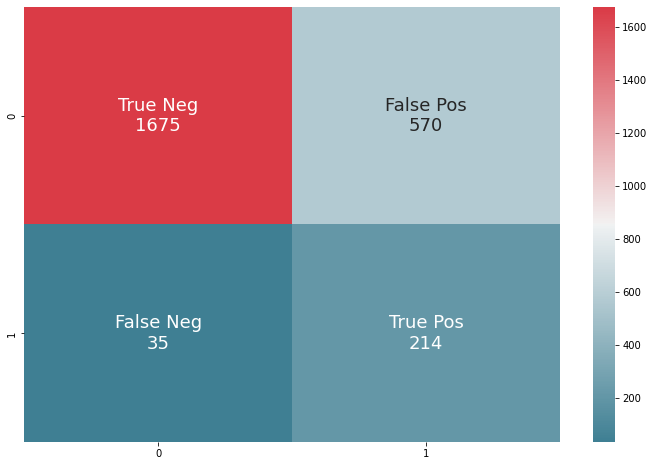

In [35]:
#Confusion matrix
cm = confusion_matrix(y_test, pred_test_rf)
plot_confusion(cm)

In [36]:
#Save model :
joblib.dump(rf_grid_rec, "models/Random_forest.pkl") 

['models/Random_forest.pkl']